# Stats: Confidence Intervals and the CLT

*Purpose*: When studying a limited dataset, we need a principled way to report our results with their uncertainties. Confidence intervals (CI) are an excellent way to summarize results, and the central limit theorem (CLT) helps us to construct these intervals. Eventually, we will use the same ideas underlying CI's to detect patterns using *statistical process monitoring*.


## Setup


In [1]:
import grama as gr
DF = gr.Intention()
%matplotlib inline

# Theory Fundamentals

To make sense of confidence intervals, we will need a bit of background information. First up: Why are we studying confidence intervals?

## Motivation: We might have seen other data

Anytime we have a *particular* dataset, we should keep in mind that *we might have seen other data*.

As a real example, let's take a real dataset and split it in two. The following code loads a datset of `tensile_strength` values and splits the full dataset into two smaller datasets. We could have seen either of these two datasets, had we gathered half as many values.


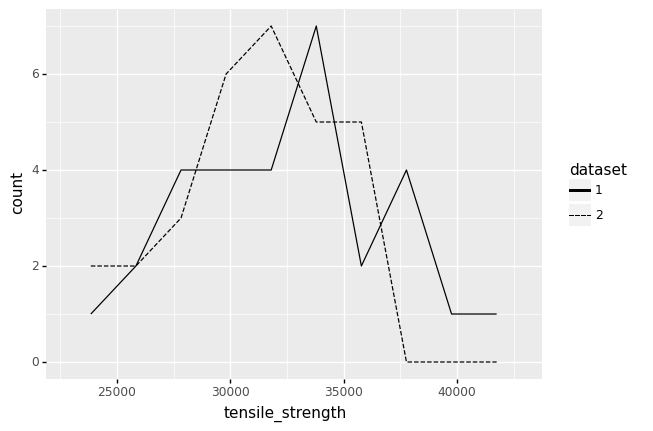

<ggplot: (8782076094004)>

In [2]:
from grama.data import df_shewhart

(
    df_shewhart
    >> gr.tf_mutate(dataset=DF.index % 2 + 1)
    >> gr.ggplot(gr.aes("tensile_strength"))
    + gr.geom_freqpoly(gr.aes(linetype="factor(dataset)"), bins=10)
    + gr.scale_linetype_discrete(name="dataset")
)

We would draw different conclusions from these two different datasets. Dataset 1 has several observations with values over `~37,500` psi. However, Dataset 2 has no observations with values this large. In practice, we would have access to just one dataset; if we happened to have Dataset 2, we might assume that values of `tensile_strength` greater than `37,500` psi do not occur. Part of thinking statistically is keeping in mind possibilities like the one we see above: *we might have seen other data*.


To underscore this idea of limited data, let's look at a simulated example. The following code defines a distribution with a specified mean.

In [3]:
## NOTE: No need to edit; run and inspect
# Define an uncertain quantity
mg_test = gr.marg_mom(
    "uniform", 
    mean=0, 
    sd=1,
)

mg_test


/Users/zach/Git/py_grama/grama/marginals.py:336: RuntimeWarning: divide by zero encountered in double_scalars


(+0) uniform, {'mean': '0.000e+00', 's.d.': '1.000e+00', 'COV': inf, 'skew.': 0.0, 'kurt.': 1.8}

From the marginal summary, we can see that the mean of the distribution is `0`. However, if we have limited data then the mean of that sample will generally not be exactly zero:


In [4]:
## NOTE: No need to edit; run and inspect
# The true mean == 0; let's see what a limited sample gives
gr.mean(mg_test.r(10))


0.20323196014235362

Limited data leads to a form of error called *sampling error*. In practice we *almost always* have limited data, so sampling error is an unavoidable reality.


## Sampling Distribution

Let's imagine for a moment that we *did* carry out data collection multiple times. Let's illustrate this by splitting the tensile strength dataset into six separate subsets.


In [5]:
# Compute a set of estimates
(
    df_shewhart
    # Split into 6 groups
    >> gr.tf_mutate(dataset=DF.specimen % 6 + 1)
    # Compute the mean and variance over each sample
    >> gr.tf_group_by(DF.dataset)
    >> gr.tf_summarize(
        tys_mu=gr.mean(DF.tensile_strength),
        n=gr.n(DF.index),
    )
    >> gr.tf_ungroup()
)

,dataset,tys_mu,n
0,1,31936.6,10
1,2,30784.4,10
2,3,32413.4,10
3,4,35654.0,10
4,5,28975.0,10
5,6,31452.8,10


Note that the mean `tys_mu` is *different* for each of the datasets. This is an example of *sampling error* (also called *sampling variability*). Statisticians quantify sampling error by defining a *population* from which a smaller dataset is drawn. This smaller dataset is called a *sample*. In the `tensile_strength` case, the population is the *infinite* number of parts that could be manufactured according to the same process. Any time we make a finite number of parts (any real batch of parts!), we have a limited sample from the manufacturing process.

```{admonition} Sample vs Population
A *population* is the full set of values we are interested in. A *sample* is a small subset from that population. Since the sample is not the population, it has less information than the full population. A mismatch between information in the population and information in the sample (e.g., the population mean vs sample mean) is called *sampling error*.
```


The *sampling distribution* is a conceptual tool used to quantify sampling variability in a chosen summary. Imagine that we repeatedly draw **random** samples (small datasets) of the same size from the target population. We then compute our chosen summary.

The following code defines a population `mg_uniform`, draws samples of size `n=10`, and computes the sample mean. The true mean is `mean == 0`; the variability we see around this value is sampling variability.


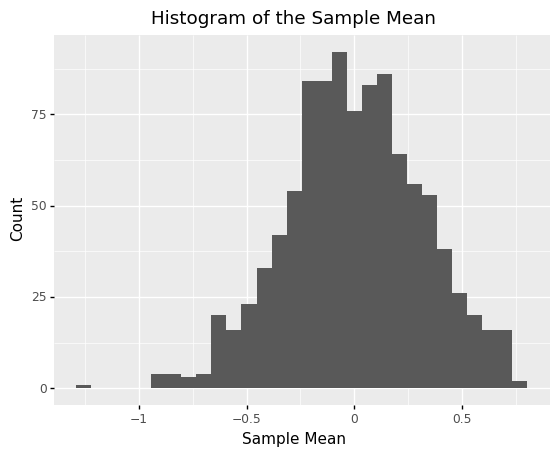

<ggplot: (8782076781294)>

In [6]:
# Define a uniform distribution
# NOTE: The true mean is set here: `mean=0`
mg_uniform = gr.marg_mom("uniform", mean=0, sd=1)

# Simulated example
n = 10   # Sample size
m = 1000 # Number of samples

(
    # Generate m=1000 samples of size n=10
    gr.df_make(x=mg_uniform.r(n * m))
    >> gr.tf_mutate(group=DF.index % m)
    # Compute mean according to each sample
    >> gr.tf_group_by(DF.group)
    >> gr.tf_summarize(x_mean=gr.mean(DF.x))
    >> gr.tf_ungroup()
    # Visualize
    >> gr.ggplot(gr.aes("x_mean"))
    + gr.geom_histogram(bins=30)
    + gr.labs(
        x="Sample Mean",
        y="Count",
        title="Histogram of the Sample Mean",
    )
)

Sampling distributions are not limited to the mean! The following code defines the same population `mg_uniform`, the same sample size `n=10`, but computes the probability that `X <= 0` rather than the mean. Note that the resulting sampling distribution looks quite different than the previous example.


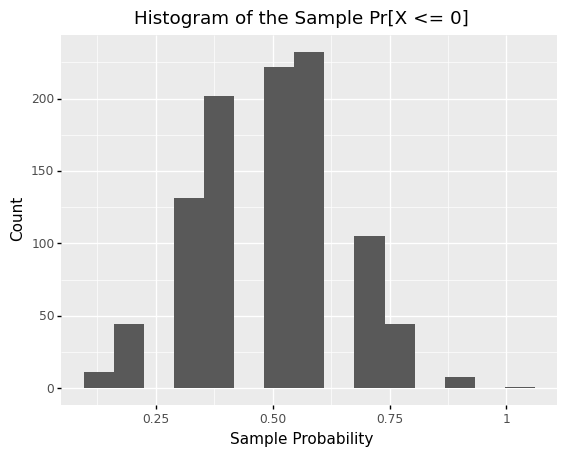

<ggplot: (8782076769856)>

In [7]:
# Define a uniform distribution
# NOTE: The true mean is set here: `mean=0`
mg_uniform = gr.marg_mom("uniform", mean=0, sd=1)

# Simulated example
n = 10   # Sample size
m = 1000 # Number of samples

(
    # Generate m=1000 samples of size n=10
    gr.df_make(x=mg_uniform.r(n * m))
    >> gr.tf_mutate(group=DF.index % m)
    # Compute mean according to each sample
    >> gr.tf_group_by(DF.group)
    >> gr.tf_summarize(pr_lo=gr.pr(DF.x <= 0))
    >> gr.tf_ungroup()
    # Visualize
    >> gr.ggplot(gr.aes("pr_lo"))
    + gr.geom_histogram(bins=15)
    + gr.labs(
        x="Sample Probability",
        y="Count",
        title="Histogram of the Sample Pr[X <= 0]",
    )
)

```{admonition} The Sampling Distribution is based on Population, Sample Size, and Summary
The sampling distribution is a result of three ingredients: 1. The target population, 2. The chosen sample size, and 3. The chosen summary. The sampling distribution also assumes that each sample is drawn randomly from the population.
```

The sampling distribution is what we would observe under *repeated* data collection. However, gathering multiple datasets of the same size and computing independent summaries would be a highly inefficient way to use data! Instead, we can use the *central limit theorem* as a means to approximate a sampling distribution using *just one dataset*.


## Central Limit Theorem (CLT)

The central limit theorem (CLT) is most easily stated in terms of the sample mean. Let $X \sim \rho$ be a random draw from a population with finite mean $\mu$ and variance $\sigma^2$. The sample mean is denoted $\overline{X}_n$ and is defined as

$$\overline{X}_n = \frac{1}{n} \sum_{i=1}^n X_i.$$

Under independent, repeated observations from the same distribution $X_i \sim \rho$, the central limit theorem states that $\overline{X}_n$ becomes increasingly normal in its distribution as $n$ is increased, regardless of the original distribution $\rho$. That is

$$\overline{X}_n \stackrel{d}{\to} N(\mu, \sigma^2/n),$$

where $\stackrel{d}{\to}$ means "convergence in distribution." The CLT is useful because it gives us a way to quantify sampling error: Since the CLT holds regardless of where the data came from $X \sim \rho$---so long as $|\mu| < \infty, \sigma < \infty$---then we can characterize the sampling error in the sample mean $\overline{X}_n$.


### __q1__ Study CLT convergence behavior

Adjust the sample size `n` below, run the code to inspect the results each time, then answer the questions under *observations* below.


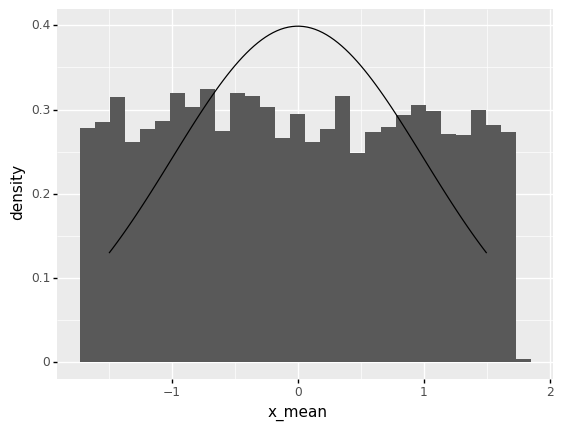

<ggplot: (8782085134111)>

In [8]:
## TODO: Adjust the sample size n
n = 1 # Sample size

## NOTE: No need to edit
# Draw a large sample
df_sample = gr.df_make(x=mg_test.r(5000))

(
    # Compute mean within each group
    df_sample
    >> gr.tf_mutate(i=DF.index // n)
    >> gr.tf_group_by(DF.i)
    >> gr.tf_summarize(
        x_mean=gr.mean(DF.x)
    )
    >> gr.tf_ungroup()
    
    # Visualize
    >> gr.ggplot(gr.aes("x_mean"))
    + gr.geom_histogram(gr.aes(y="stat(density)"), bins=30)
    + gr.geom_line(
        data=gr.df_make(x_mean=gr.linspace(-1.5, +1.5, 100))
        >> gr.tf_mutate(
            d=gr.marg_mom("norm", mean=0, sd=1/gr.sqrt(n)).d(DF.x_mean)
        ),
        mapping=gr.aes(y="d"),
    )
)

*Observations*

- Around what value of $n$ does the histogram start to look like the normal distribution (black curve)?
  - Around values of $n > 10$ the histogram starts to look like a normal distribution.
- How does the "width" of the histogram change with $n$?
  - The "width" of the histogram tends to shrink with large $n$, but it shrinks very slowly.


## Confidence Intervals (CI)

Since any estimated quantity has sampling error, it is common to report estimated values along with a *confidence interval*. A confidence interval (CI) is an expression of *uncertainty*; it will tend to be wider when the sampling error is larger. For the moment, let's talk about how to *compute* a confidence interval; we'll discuss how to *interpret* a confidence interval in a bit.

The CLT-based confidence interval for the mean is given by

$$[\overline{X}_n - z_C \sigma/\sqrt{n}, \overline{X}_n + z_C \sigma/\sqrt{n}]$$

where $z_C$ is the relevant quantile of a standard normal distribution. This is based on capturing a specified fraction $C$ of the distribution between the interval bounds. For instance, the following code computes $z_C$ for $C = 0.99$.

```{admonition} Terminology: Point Estimate vs Confidence Interval
A single value like a sample mean $\overline{X}_n$ is called a *point estimate*, while a confidence interval is defined by two values (the interval endpoints).
```


In [9]:
## NOTE: No need to edit, this computes the relevant z_C value
C = 0.99 # 99% confidence level
mg_standard = gr.marg_mom("norm", mean=0, sd=1)
z_C = mg_standard.q(1 - (1 - C)/2)
print("z_C = {0:4.3f}".format(z_C))


z_C = 2.576


You can compute these CI bounds manually. However, the helper functions `gr.mean_lo()` and `gr.mean_up()` automate these calculations. For both functions, you can adjust the confidence level `C` with the `alpha` parameter.

### __q2__ Compute a confidence interval

Use the helper functions `gr.mean_lo()` and `gr.mean_up()` to compute confidence limits for the mean.


In [10]:
## TODO: Compute confidence limits for the mean;
df_ci = (
    gr.df_make(x=mg_test.r(10))
    >> gr.tf_summarize(
        x_lo=gr.mean_lo(DF.x),

        x_mean=gr.mean(DF.x),
        x_up=gr.mean_up(DF.x),

    )
)

## NOTE: Use this to check your work
assert \
    "x_lo" in df_ci.columns, \
    "You must compute x_lo"
assert \
    "x_up" in df_ci.columns, \
    "You must compute x_up"
assert \
    df_ci.x_lo[0] < df_ci.x_mean[0], \
    "x_lo should be smaller than x_mean"
assert \
    df_ci.x_mean[0] < df_ci.x_up[0], \
    "x_mean should be smaller than x_up"

df_ci

,x_lo,x_mean,x_up
0,-0.540023,0.210576,0.961175


### __q3__ Study the CI width

The following code creates confidence intervals for samples of different sizes $n$. Run the following code, inspect the results, and answer the questions under *observations* below.


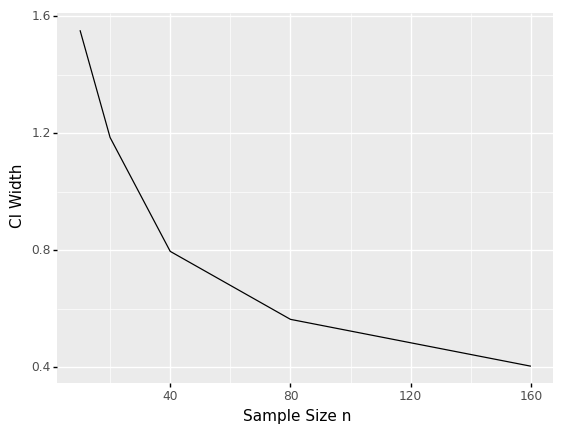

<ggplot: (8782085128695)>

In [11]:
## NOTE: No need to edit
df_sweep = gr.df_grid()
for i in [10, 20, 40, 80, 160]:
    df_sweep = (
        df_sweep
        >> gr.tf_bind_rows(
            gr.df_make(x=mg_test.r(i))
            >> gr.tf_summarize(
                x_lo=gr.mean_lo(DF.x),
                x_up=gr.mean_up(DF.x),
            )
            >> gr.tf_mutate(
                ci_width=DF.x_up - DF.x_lo,
                n=i,
            )
        )
    )
    
(
    df_sweep
    >> gr.ggplot(gr.aes("n", "ci_width"))
    + gr.geom_line()
    + gr.labs(
        x="Sample Size n",
        y="CI Width",
    )
)

*Observations*

- Compare the CI width behavior (figure immediately above) with the definition given earlier. What explains the curve above?
  - The CI expression contains a $\sigma/\sqrt{n}$ term; the $1/\sqrt{n}$ behavior is what we see above.
- To halve the CI width, how would you need to change the sample size?
  - To halve the CI width, you would need to quadruple the sample size; note that the width goes as $1/\sqrt{n}$, thus $1/\sqrt{4n} = 1/(2\sqrt{n})$. 
<!-- solution-end -->

# Interpreting Confidence Intervals

Confidence intervals are constructed in a way that seeks to *include* the true value that we seek to estimate. However, the nature of uncertainty means we need to exercise care when interpreting a confidence interval.

## Golden Rule of Confidence Intervals

```{admonition} The "Golden Rule" for interpreting Confidence Intervals
When interpreting a confidence interval, we should assume the true value could be anywhere inside the interval.
```

Interpreting a CI as a range of possibilities helps us "hedge our bets". The point estimate may suggest a favorable conclusion, but if the CI is wide, then an unfavorable conclusion may also be possible.

If a CI does not allow you to exclude an unfavorable possibility, it is an indication that you should gather another *larger* sample in order to study the same problem with greater statistical precision. You'll practice these ideas in the following exercises.

```{admonition} Confidence in *procedure*, not in the interval
:class: warning
A subtle point about confidence intervals is that our confidence is in the long-run properties of constructing *many* intervals, not in any *single* interval. Any individual interval either does or does not include its true value: the "probability" for a single interval is either `0` or `1`.
```


### __q4__ Interpret these intervals

Study the following intervals, answer the questions under *observations* below.


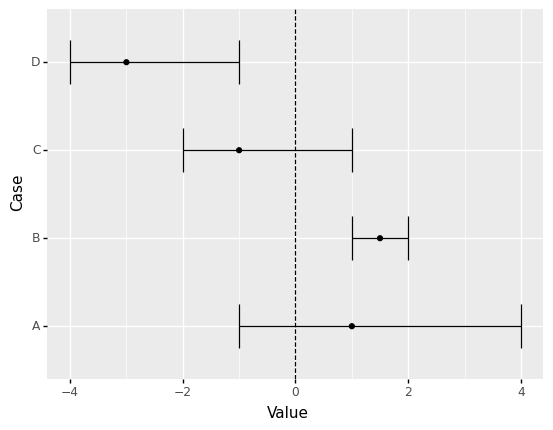

<ggplot: (8782105817853)>

In [12]:
## NOTE: No need to edit; run and inspect
(
    gr.df_make(
        case=["A", "B", "C", "D"],
        x_lo=[ -1,   1,  -2,  -4],
        x_mu=[  1, 1.5,  -1,  -3],
        x_up=[  4,   2,   1,  -1],
    )
    >> gr.ggplot(gr.aes("case"))
    + gr.geom_errorbar(gr.aes(ymin="x_lo", ymax="x_up"))
    + gr.geom_point(gr.aes(y="x_mu"))
    + gr.geom_hline(yintercept=0, linetype="dashed")
    + gr.coord_flip()
    + gr.labs(
        y="Value",
        x="Case",
    )
)

*Observations*

- Is Case A greater than zero?
  - Unclear; the confidence interval includes zero, so A could very well be negative.
- Is Case B greater than zero?
  - Most likely yes; the entire confidence interval is greater than zero.
- Is Case C less than zero?
  - Unclear; the confidence interval includes zero, so C could very well be positive.
- Is Case D less than zero?
  - Most likely yes; the entire confidence interval is less than zero.
<!-- solution-end -->

# Probability Estimation

Remember that we learned in the previous exercise [stat04-distributions](https://zdelrosario.github.io/evc-course/exercises_solution/d19-e-stat04-distributions-solution.html#probability) that probability can be expressed as a mean (expectation). Thus, we can apply the same ideas about confidence intervals when estimating probabilities.

To demonstrate, let's study a simple structural model.

In [13]:
from grama.models import make_cantilever_beam
md_beam = make_cantilever_beam()
md_beam

model: Cantilever Beam

  inputs:
    var_det:
      t: [2, 4]
      w: [2, 4]

    var_rand:
      H: (+1) norm, {'mean': '5.000e+02', 's.d.': '1.000e+02', 'COV': 0.2, 'skew.': 0.0, 'kurt.': 3.0}
      V: (+1) norm, {'mean': '1.000e+03', 's.d.': '1.000e+02', 'COV': 0.1, 'skew.': 0.0, 'kurt.': 3.0}
      E: (+0) norm, {'mean': '2.900e+07', 's.d.': '1.450e+06', 'COV': 0.05, 'skew.': 0.0, 'kurt.': 3.0}
      Y: (-1) norm, {'mean': '4.000e+04', 's.d.': '2.000e+03', 'COV': 0.05, 'skew.': 0.0, 'kurt.': 3.0}

    copula:
      Independence copula

  functions:
      cross-sectional area: ['w', 't'] -> ['c_area']
      limit state: stress: ['w', 't', 'H', 'V', 'E', 'Y'] -> ['g_stress']
      limit state: displacement: ['w', 't', 'H', 'V', 'E', 'Y'] -> ['g_disp']

This model has two outputs that model failure modes: `g_stress <= 0` when the beam exceeds its maximum stress, and `g_disp <= 0` when the tip deflection is beyond its designed limit. We can assess the probability of failure for both failure modes:

In [14]:
# NOTE: No need to edit
(
    md_beam
    >> gr.ev_sample(n=100, df_det="nom")
    >> gr.tf_summarize(
        pof_stress=gr.pr(DF.g_stress <= 0),
        pof_disp=gr.pr(DF.g_disp <= 0),
    )
)

,pof_stress,pof_disp
0,0.06,0.06


Like the mean CI helpers, grama provides `gr.pr_lo()` and `gr.pr_up()` to easily compute confidence intervals on a probability:

```{admonition} The probability CI helpers are different
Note that the probability CI helpers `gr.pr_lo()` and `gr.pr_up()` are different from `gr.mean_lo()` and `gr.mean_up()`; namely, they only return values between `[0, 1]`. Make sure to only use the probability helpers when estimating probabilities!
```


In [15]:
## NOTE: No need to edit; run and inspect
(
    md_beam
    >> gr.ev_sample(n=100, df_det="nom", seed=101)
    >> gr.tf_summarize(
        pof_lo=gr.pr_lo(DF.g_stress <= 0),
        pof=gr.pr(DF.g_stress <= 0),
        pof_up=gr.pr_up(DF.g_stress <= 0),
    )
)

,pof_lo,pof,pof_up
0,0.003477,0.02,0.106641


This is an *extremely* wide confidence interval for the probability of failure; I get a value of `pof` anywhere between `0.003` and `0.11`!

### __q5__ Adjust the sample size

Adjust the sample size `n` to achieve a CI width less than `0.1`.  Answer the questions under *observations* below.


In [16]:
## TODO: Adjust the sample size
df_pof = (
    md_beam
    >> gr.ev_sample(

        n=5e4, 
        df_det="nom",
    )
    >> gr.tf_summarize(
        pof_lo=gr.pr_lo(DF.g_stress <= 0),
        pof=gr.pr(DF.g_stress <= 0),
        pof_up=gr.pr_up(DF.g_stress <= 0),
    )
)

## NOTE: No need to edit; use to check your work
assert \
    abs(df_pof.pof_up[0] - df_pof.pof_lo[0]) < 0.1, \
    "CI is too wide; increase `n`"

df_pof

eval_sample() is rounding n...


,pof_lo,pof,pof_up
0,0.033094,0.03534,0.037732


*Observations*

- Is the `pof` smaller than `0.04`?
  - At a sample size of `n=5e4` I find that `pof_up ~ 0.03973`, which suggests that `pof < 0.04`. At a sample size of `n=20` (as given in the default), the upper confidence limit `pof_up` exceeds `0.04`, so we need to increase `n` in order to make this determination.
<!-- solution-end -->

### __q6__ Design for small failure rate

Adjust the deterministic variables `w` and `t` in order to *confidently* achieve a probability of failure due to stress less than `0.001`.

*Hint*: You adjusted the sample size `n` in the previous exercise. Make sure to use that learning when tackling this exercise.


In [17]:
## TODO: Adjust the deterministic variables `w, t` to achieve a probability
## of failure less than 0.001
df_pof_small = (
    md_beam
    >> gr.ev_sample(

        n=1e4, # A larger sample size is necessary for a small CI
        df_det=gr.df_make(w=3.0, t=3.5),
    )
    >> gr.tf_summarize(
        pof_lo=gr.pr_lo(DF.g_stress <= 0),
        pof=gr.pr(DF.g_stress <= 0),       # I find that pof ~= 0.0
        pof_up=gr.pr_up(DF.g_stress <= 0), # pof_up must be < 0.001
    )
)

## NOTE: Use this to check your work
print(df_pof_small)

assert \
    df_pof_small.pof_up.values[0] < 0.001, \
    "The upper CI bound for the POF is not less than 0.001"

eval_sample() is rounding n...
         pof_lo  pof    pof_up
0  5.421011e-20  0.0  0.000787


# Real vs Error

In [stat02-source](https://zdelrosario.github.io/evc-course/exercises_solution/d08-e-stat02-source-solution.html#) we learned that we should treat real and erroneous sources of variability differently. Let's apply that thinking to the beam example.

### __q7__ Selecting the proper statistical technique

Suppose the variability exhibited by the model `md_beam` is real. Study the results from the simulation below, and answer the questions under *observations* below.


In [18]:
## TODO: No need to edit; run and inspect the results
(
    md_beam
    >> gr.ev_sample(
        n=1e4, 
        df_det="nom",
    )
    >> gr.tf_summarize(
        g_lo=gr.mean_lo(DF.g_stress),
        g_mean=gr.mean(DF.g_stress),
        g_up=gr.mean_up(DF.g_stress),

        pof_lo=gr.pr_lo(DF.g_stress <= 0),
        pof=gr.pr(DF.g_stress <= 0),
        pof_up=gr.pr_up(DF.g_stress <= 0),
    )
)

eval_sample() is rounding n...


,g_lo,g_mean,g_up,pof_lo,pof,pof_up
0,0.165897,0.168285,0.170674,0.032335,0.0373,0.042994


*Observations*

- Is the variability in `g_stress` real or erroneous?
  - We're assuming that the variability exhibited by this model is real, so the variability in `g_stress` is real.
- Is the mean of `g_stress` greater than zero?
  - Yes; the confidence interval for `g_stress` is entirely above zero (`0 < g_lo`).
- What is the probability of failure due to stress?
  - The probability of failure is between `[0.03, 0.04]`; it is fairly small but non-negligible.
- Which of the two statistical techniques---computing the mean or computing a probability of failure---better characterizes the safety of this system? Why?
  - The probability of failure better characterizes the safety of the system. Remember that the mean is most appropriate when variability is purely error, so it is an inappropriate summary of the behavior of this system. A probability of failure is a very natural measure of safety.
<!-- solution-end -->